In [ ]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tree import Tree
from nltk import word_tokenize, pos_tag, ne_chunk, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import defaultdict
import string
from transformers import pipeline
import numpy as np # linear algebra
import warnings
warnings.filterwarnings('ignore')

# Download the required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, RocCurveDisplay, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler



from google.colab import drive
drive.mount('/content/drive')

airline_data = pd.read_csv('/content/drive/MyDrive/Text Mining/Airline_Reviews.csv')

# Display the first few rows of the dataframe to understand its structure and contents

airline_data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


In [ ]:
# Checking for missing values and data types
missing_values = airline_data.isnull().sum()
data_types = airline_data.dtypes

missing_values, data_types


(Unnamed: 0                    0
 Airline Name                  0
 Overall_Rating                0
 Review_Title                  0
 Review Date                   0
 Verified                      0
 Review                        0
 Aircraft                  16042
 Type Of Traveller          3738
 Seat Type                  1096
 Route                      3828
 Date Flown                 3754
 Seat Comfort               4155
 Cabin Staff Service        4260
 Food & Beverages           8671
 Ground Service             4793
 Inflight Entertainment    12342
 Wifi & Connectivity       17251
 Value For Money            1066
 Recommended                   0
 dtype: int64,
 Unnamed: 0                  int64
 Airline Name               object
 Overall_Rating             object
 Review_Title               object
 Review Date                object
 Verified                     bool
 Review                     object
 Aircraft                   object
 Type Of Traveller          object
 Seat Type

In [ ]:
# Data Cleaning and Organization

# Converting 'Overall_Rating' to a numerical type
# We first need to ensure that all values in 'Overall_Rating' can be converted to numbers
# We will replace non-numeric values with NaN and then convert the column to float
airline_data['Overall_Rating'] = pd.to_numeric(airline_data['Overall_Rating'], errors='coerce')

# Renaming the 'Unnamed: 0' column to 'Review_ID'
airline_data.rename(columns={'Unnamed: 0': 'Review_ID'}, inplace=True)

# Checking for non-numeric values in 'Overall_Rating' and the updated DataFrame structure
non_numeric_ratings = airline_data['Overall_Rating'].isnull().sum()
updated_structure = airline_data.dtypes

non_numeric_ratings, updated_structure


(842,
 Review_ID                   int64
 Airline Name               object
 Overall_Rating            float64
 Review_Title               object
 Review Date                object
 Verified                     bool
 Review                     object
 Aircraft                   object
 Type Of Traveller          object
 Seat Type                  object
 Route                      object
 Date Flown                 object
 Seat Comfort              float64
 Cabin Staff Service       float64
 Food & Beverages          float64
 Ground Service            float64
 Inflight Entertainment    float64
 Wifi & Connectivity       float64
 Value For Money           float64
 Recommended                object
 dtype: object)

In [ ]:
# Converting 'Overall_Rating' to a numerical type
airline_data['Overall_Rating'] = pd.to_numeric(airline_data['Overall_Rating'], errors='coerce')

# Renaming the 'Unnamed: 0' column to 'Review_ID'
airline_data.rename(columns={'Unnamed: 0': 'Review_ID'}, inplace=True)

# Handling missing values for ratings by imputing with the median
rating_columns = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
                  'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money']

for col in rating_columns:
    median_value = airline_data[col].median()
    airline_data[col].fillna(median_value, inplace=True)

# Converting 'Review Date' and 'Date Flown' to datetime format
airline_data['Review Date'] = pd.to_datetime(airline_data['Review Date'], errors='coerce')
airline_data['Date Flown'] = pd.to_datetime(airline_data['Date Flown'], errors='coerce')

# Creating a new column 'Rating Category' to categorize overall ratings
airline_data['Rating Category'] = pd.cut(airline_data['Overall_Rating'], bins=[0, 3, 7, 10], labels=['Low', 'Medium', 'High'])

# Checking the updated DataFrame and summary of changes
updated_summary = airline_data[['Overall_Rating', 'Review Date', 'Date Flown', 'Rating Category']].describe(include='all')
updated_summary, airline_data.dtypes

(        Overall_Rating          Review Date           Date Flown  \
 count     22329.000000                23171                19417   
 unique             NaN                 4557                  109   
 top                NaN  2023-07-16 00:00:00  2023-06-01 00:00:00   
 freq               NaN                   67                 1057   
 first              NaN  2002-01-06 00:00:00  2012-04-01 00:00:00   
 last               NaN  2023-07-27 00:00:00  2023-08-01 00:00:00   
 mean          3.144297                  NaN                  NaN   
 std           2.879391                  NaN                  NaN   
 min           1.000000                  NaN                  NaN   
 25%           1.000000                  NaN                  NaN   
 50%           1.000000                  NaN                  NaN   
 75%           5.000000                  NaN                  NaN   
 max           9.000000                  NaN                  NaN   
 
        Rating Category  
 count

In [ ]:


# Converting 'Overall_Rating' to a numerical type and renaming 'Unnamed: 0' to 'Review_ID'
airline_data['Overall_Rating'] = pd.to_numeric(airline_data['Overall_Rating'], errors='coerce')
airline_data.rename(columns={'Unnamed: 0': 'Review_ID'}, inplace=True)

# Removing all columns except the specified ones
columns_to_keep = ['Airline Name', 'Overall_Rating', 'Review_Title', 'Review', 'Recommended']
airline_data_reduced = airline_data[columns_to_keep]

# Displaying the first few rows of the updated DataFrame
airline_data_reduced.head()


,Airline Name,Overall_Rating,Review_Title,Review,Recommended
0,AB Aviation,9.0,"""pretty decent airline""",Moroni to Moheli. Turned out to be a pretty ...,yes
1,AB Aviation,1.0,"""Not a good airline""",Moroni to Anjouan. It is a very small airline...,no
2,AB Aviation,1.0,"""flight was fortunately short""",Anjouan to Dzaoudzi. A very small airline an...,no
3,Adria Airways,1.0,"""I will never fly again with Adria""",Please do a favor yourself and do not fly wi...,no
4,Adria Airways,1.0,"""it ruined our last days of holidays""",Do not book a flight with this airline! My fr...,no


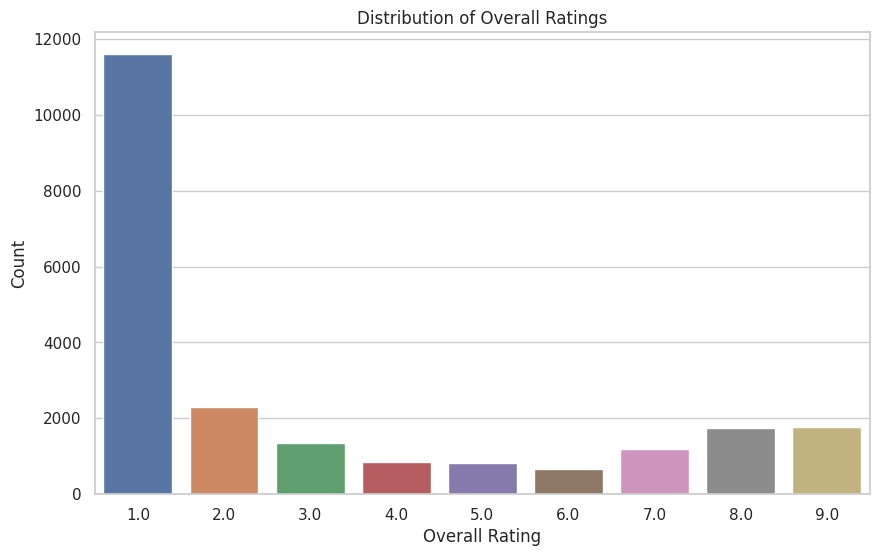

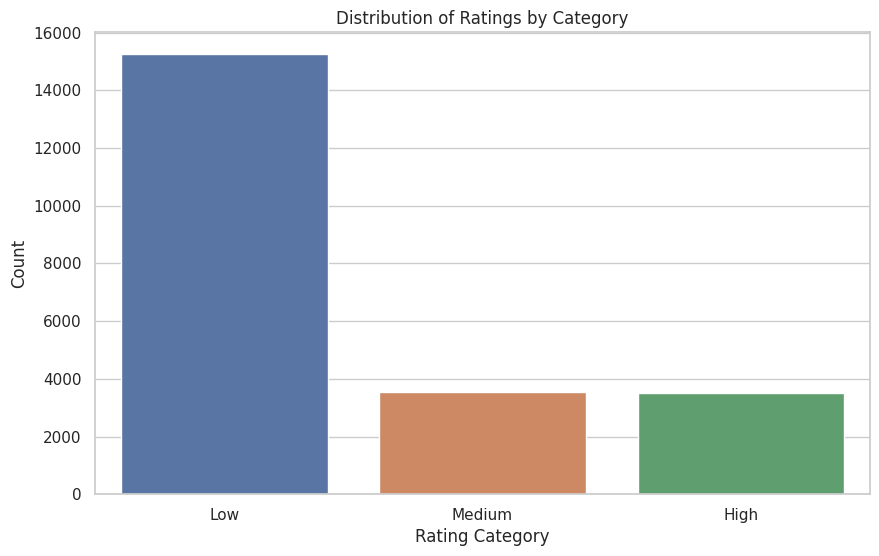

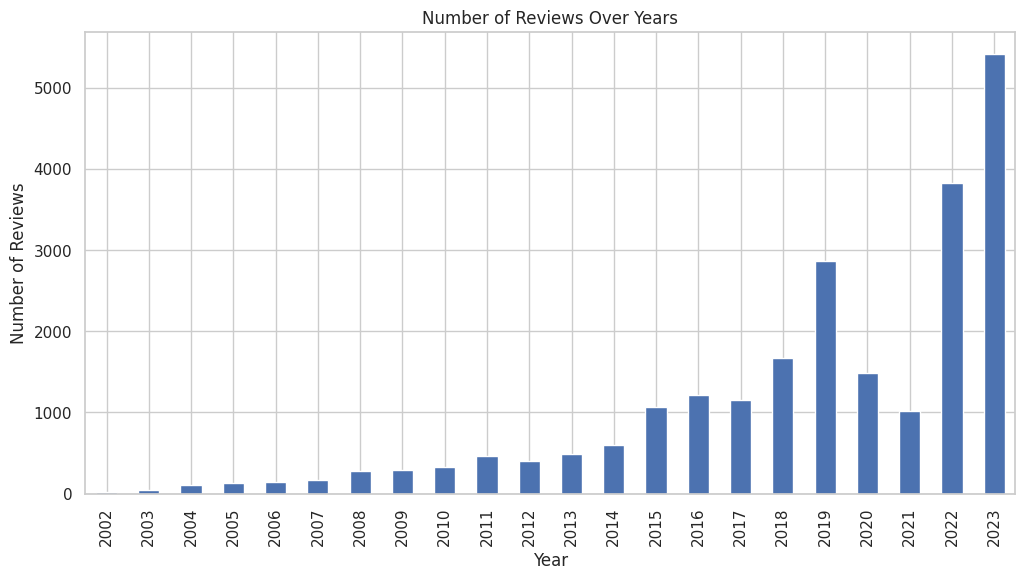

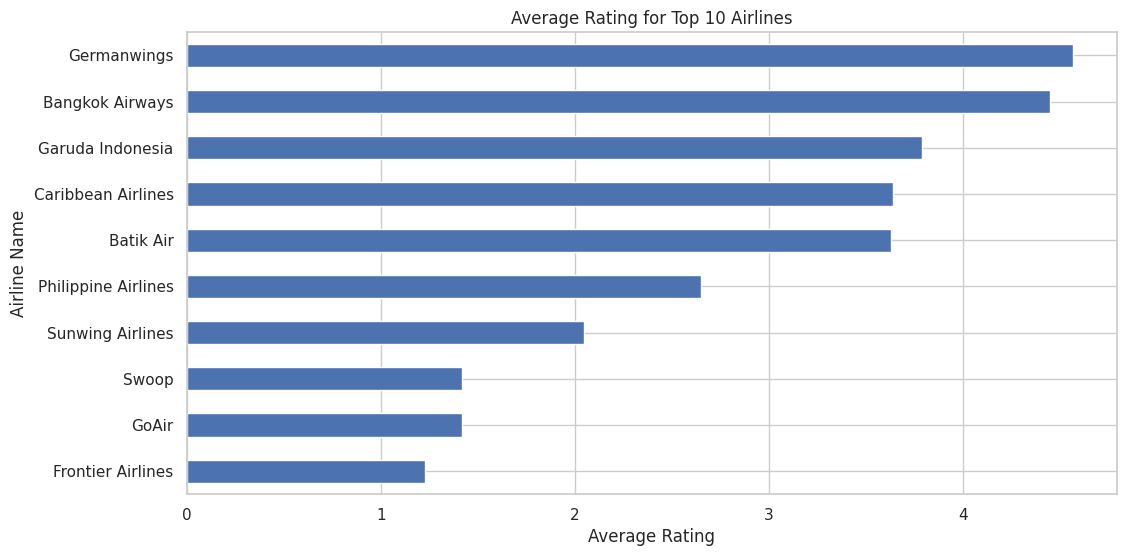

In [ ]:

# Setting the style for the plots
sns.set(style="whitegrid")

# Visualizations

# 1. Distribution of Overall Ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='Overall_Rating', data=airline_data)
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()

# 2. Distribution of Ratings by Category
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating Category', data=airline_data, order=['Low', 'Medium', 'High'])
plt.title('Distribution of Ratings by Category')
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.show()

# 3. Number of Reviews Over Time (Year)
plt.figure(figsize=(12, 6))
airline_data['Review Date'].groupby(airline_data["Review Date"].dt.year).count().plot(kind='bar')
plt.title('Number of Reviews Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()

# 4. Average Rating for Top 10 Airlines (with most reviews)
top_airlines = airline_data['Airline Name'].value_counts().head(10).index
avg_ratings_top_airlines = airline_data[airline_data['Airline Name'].isin(top_airlines)].groupby('Airline Name')['Overall_Rating'].mean()
plt.figure(figsize=(12, 6))
avg_ratings_top_airlines.sort_values().plot(kind='barh')
plt.title('Average Rating for Top 10 Airlines')
plt.xlabel('Average Rating')
plt.ylabel('Airline Name')
plt.show()



In [ ]:
# Combining 'Review_Title' and 'Review' into a single column
airline_data_reduced['Combined_Review'] = airline_data_reduced['Review_Title'] + " " + airline_data_reduced['Review']

# Displaying the first few rows of the updated DataFrame to verify the combination
airline_data_reduced.head()


,Airline Name,Overall_Rating,Review_Title,Review,Recommended,Combined_Review
0,AB Aviation,9.0,"""pretty decent airline""",Moroni to Moheli. Turned out to be a pretty ...,yes,"""pretty decent airline"" Moroni to Moheli. Tu..."
1,AB Aviation,1.0,"""Not a good airline""",Moroni to Anjouan. It is a very small airline...,no,"""Not a good airline"" Moroni to Anjouan. It is..."
2,AB Aviation,1.0,"""flight was fortunately short""",Anjouan to Dzaoudzi. A very small airline an...,no,"""flight was fortunately short"" Anjouan to Dz..."
3,Adria Airways,1.0,"""I will never fly again with Adria""",Please do a favor yourself and do not fly wi...,no,"""I will never fly again with Adria"" Please d..."
4,Adria Airways,1.0,"""it ruined our last days of holidays""",Do not book a flight with this airline! My fr...,no,"""it ruined our last days of holidays"" Do not ..."


In [ ]:
import re
from nltk.corpus import stopwords

def preprocess_text_simple(text):

    # Removing special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    tokens = text.split()
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Then apply this function to your DataFrame column
airline_data_reduced['Processed_Review'] = airline_data_reduced['Combined_Review'].apply(preprocess_text_simple)


In [ ]:
# Display the first few rows of the DataFrame to show the results
print(airline_data_reduced[['Combined_Review', 'Processed_Review']].head())

                                     Combined_Review  \
0  "pretty decent airline"   Moroni to Moheli. Tu...   
1  "Not a good airline"  Moroni to Anjouan. It is...   
2  "flight was fortunately short"   Anjouan to Dz...   
3  "I will never fly again with Adria"   Please d...   
4  "it ruined our last days of holidays"  Do not ...   

                                    Processed_Review  
0  pretty decent airline Moroni Moheli Turned pre...  
1  Not good airline Moroni Anjouan It small airli...  
2  flight fortunately short Anjouan Dzaoudzi A sm...  
3  I never fly Adria Please favor fly Adria On ro...  
4  ruined last days holidays Do book flight airli...  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF Vectorizer instance
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed

# Fit and transform the 'Processed_Review' column
tfidf_matrix = tfidf_vectorizer.fit_transform(airline_data_reduced['Processed_Review'])

# Inspect the resulting matrix
print(tfidf_matrix.shape)  # This shows the shape of the TF-IDF matrix

# To get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names)  # This will print the words corresponding to each column in the matrix


(23171, 1000)
['10' '100' '11' '12' '14' '15' '20' '200' '2020' '2022' '2023' '24' '25'
 '30' '35' '40' '45' '50' '90' 'a320' 'able' 'absolute' 'absolutely'
 'accept' 'acceptable' 'access' 'accommodation' 'across' 'actually' 'add'
 'additional' 'advance' 'advised' 'after' 'again' 'agent' 'agents' 'ago'
 'ahead' 'air' 'airasia' 'aircraft' 'airline' 'airlines' 'airplane'
 'airport' 'airports' 'airways' 'aisle' 'all' 'allow' 'allowance'
 'allowed' 'almost' 'already' 'also' 'alternative' 'although' 'always'
 'amazing' 'american' 'amount' 'amsterdam' 'and' 'angeles' 'announced'
 'announcement' 'announcements' 'another' 'answer' 'anymore' 'anyone'
 'anything' 'apart' 'apology' 'app' 'apparently' 'april' 'area' 'around'
 'arrival' 'arrive' 'arrived' 'arriving' 'as' 'asia' 'ask' 'asked'
 'asking' 'assistance' 'at' 'athens' 'attendant' 'attendants' 'attentive'
 'attitude' 'available' 'average' 'avoid' 'away' 'awful' 'ba' 'back' 'bad'
 'bag' 'baggage' 'bags' 'bangkok' 'basic' 'basically' 'behind

In [ ]:
# Named Entity Recognition

# Install spaCy if havent
# !pip install spacy

import spacy
nlp = spacy.load('en_core_web_sm')

# Function to extract named entities using spaCy
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Assuming airline_data_reduced is your DataFrame and 'Processed_Review' is the column with processed text
# Apply the extract_entities function to each review
airline_data_reduced['Spacy_Entities'] = airline_data_reduced['Processed_Review'].apply(extract_entities)

# Now, your DataFrame has a new column 'Spacy_Entities' with the extracted entities
print(airline_data_reduced[['Processed_Review', 'Spacy_Entities']].head())

                                    Processed_Review  \
0  pretty decent airline Moroni Moheli Turned pre...   
1  Not good airline Moroni Anjouan It small airli...   
2  flight fortunately short Anjouan Dzaoudzi A sm...   
3  I never fly Adria Please favor fly Adria On ro...   
4  ruined last days holidays Do book flight airli...   

                                      Spacy_Entities  
0  [(Moheli Turned, ORG), (Online, ORG), (20 minu...  
1  [(Anjouan, PERSON), (AB Aviation, ORG), (1300h...  
2  [(Anjouan Dzaoudzi, PERSON), (Comoros Checkin,...  
3  [(Adria Please, PERSON), (Adria, ORG), (Munich...  
4  [(last days holidays, DATE), (Sofia, GPE), (Se...  


In [ ]:
# Displaying output with displacy
from IPython.display import HTML

# Function to highlight entities in the text with improved styling
def highlight_entities(doc):
    colors = {
        'ORG': '#E74C3C',   # Bright red
        'PERSON': '#2ECC71', # Vivid green
        'GPE': '#3498DB',    # Bright blue
        'DATE': '#F39C12',   # Vivid orange
        'TIME': '#9B59B6'    # Vivid purple
    }
    style = "border-radius: 3px; padding: 2px 4px; margin: 0 2px; display: inline-block;"
    text_style = "font-weight: bold; color: #333;"  # Dark text color for better readability
    highlighted_text = ""

    for token in doc:
        color = colors.get(token.ent_type_, '#f2f2f2')  # Light grey for non-entities
        highlighted_text += f"<mark style='background-color: {color}; {style}'>" \
                            f"<span style='{text_style}'>{token}</span></mark>"

    return highlighted_text

# Display the first 10 reviews with highlighted entities and list of entities
# For the header Color
header_style = "color: #ffffff; font-weight: bold; font-size: 1.2em;"

# For the entity list items:
list_item_style = "background-color: #f0f0f0; color: #000; padding: 2px 4px; margin: 2px 0; border-radius: 3px;"

# Apply the styles in the display code
for index, row in airline_data_reduced.head(10).iterrows():
    doc = nlp(row['Processed_Review'])
    entities_html = "".join([f"<li style='{list_item_style}'>{ent.text} ({ent.label_})</li>" for ent in doc.ents])
    entities_html = f"<ul style='list-style-type: none; padding: 0;'>{entities_html}</ul>"

    display(HTML(f"<div style='margin-bottom: 20px;'><h3 style='{header_style}'>Review {index + 1}:</h3>"))
    display(HTML(f"<div style='background: #f9f9f9; border-left: 6px solid #ccc; padding: 15px; margin: 10px 0;'>{highlight_entities(doc)}{entities_html}</div>"))



In [ ]:
# William's Part - Sentiment Analysis


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
airline_df = pd.read_csv('/content/drive/MyDrive/Text Mining/Airline_Reviews.csv')

# Find the count of unique values in the index
airline_df['Overall_Rating'].value_counts()

1    11595
2     2296
9     1768
8     1757
3     1356
7     1192
4      859
n      842
5      830
6      676
Name: Overall_Rating, dtype: int64

In [ ]:
# Since there are some ratings with n value, then replace n with 0
def convert(rating):
    if rating == 'n':
        return '0'
    else:
        return rating

airline_df['Overall_Rating'] = airline_df['Overall_Rating'].apply(lambda x: convert(x))
airline_df['Overall_Rating'].value_counts()

1    11595
2     2296
9     1768
8     1757
3     1356
7     1192
4      859
0      842
5      830
6      676
Name: Overall_Rating, dtype: int64

In [ ]:
airline_df['Overall_Rating'] = airline_df['Overall_Rating'].astype(int)

# Convert Overall_Rating columns into only 4 different values
airline_df['New_Ratings'] = pd.cut(airline_df['Overall_Rating'], 4, labels = [1,2,3,4])
airline_df['New_Ratings'].unique()

[4, 1, 2, 3]
Categories (4, int64): [1 < 2 < 3 < 4]

In [ ]:
# Get rid of Overall_Rating column since New_Ratings column available
airline_df = airline_df.drop(['Overall_Rating', 'Unnamed: 0'], axis = 1)

airline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Airline Name            23171 non-null  object  
 1   Review_Title            23171 non-null  object  
 2   Review Date             23171 non-null  object  
 3   Verified                23171 non-null  bool    
 4   Review                  23171 non-null  object  
 5   Aircraft                7129 non-null   object  
 6   Type Of Traveller       19433 non-null  object  
 7   Seat Type               22075 non-null  object  
 8   Route                   19343 non-null  object  
 9   Date Flown              19417 non-null  object  
 10  Seat Comfort            19016 non-null  float64 
 11  Cabin Staff Service     18911 non-null  float64 
 12  Food & Beverages        14500 non-null  float64 
 13  Ground Service          18378 non-null  float64 
 14  Inflight Entertainment

In [ ]:
# Handle the NULL values

# Dropping 'Aircraft', 'Wifi & Connectivity', 'Route' and 'Inflight Entertainment' columns.
airline_df = airline_df.drop(['Aircraft', 'Wifi & Connectivity', 'Route', 'Inflight Entertainment'], axis = 1)

# Dropping the rows which 'Food & Beverages' is null.
airline_df = airline_df.dropna(axis = 0, subset = ['Food & Beverages'])

airline_df.head()

# Count the number of missing values in the dataset
airline_df.isnull().sum()

Airline Name              0
Review_Title              0
Review Date               0
Verified                  0
Review                    0
Type Of Traveller      1388
Seat Type                16
Date Flown             1398
Seat Comfort              1
Cabin Staff Service       1
Food & Beverages          0
Ground Service         1392
Value For Money           0
Recommended               0
New_Ratings               0
dtype: int64

<Axes: xlabel='Verified', ylabel='count'>

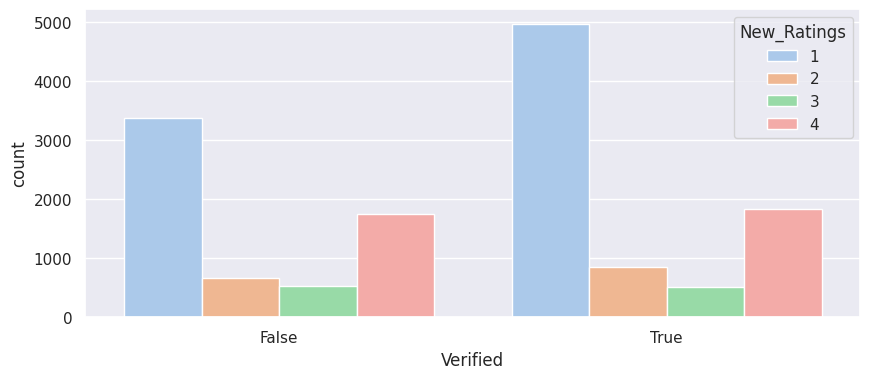

In [ ]:
# Drop the Airline Name column as it has over 400 different names
airline_df = airline_df.drop('Airline Name', axis = 1)

# Plot of Verified and New_Ratings
sns.set_theme(style = 'darkgrid', palette = 'pastel')
plt.figure(figsize = (10, 4))
sns.countplot(data = airline_df, x = 'Verified', hue = 'New_Ratings')

<Axes: xlabel='Recommended', ylabel='count'>

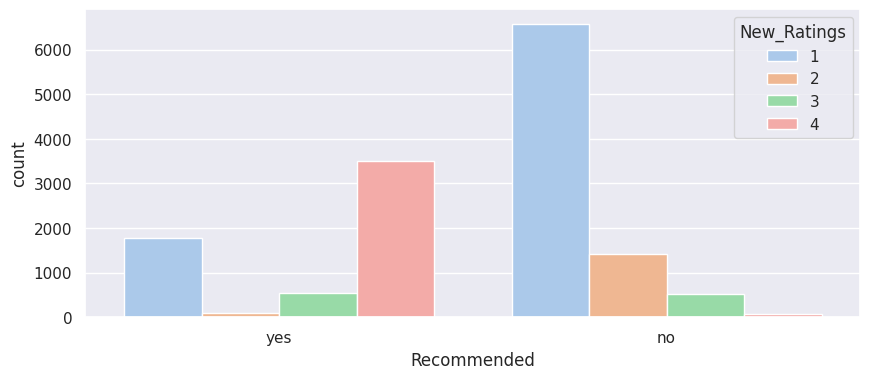

In [ ]:
# Plot of Recommended and New_Ratings
sns.set_theme(style = 'darkgrid', palette = 'pastel')
plt.figure(figsize = (10, 4))
sns.countplot(data = airline_df, x = 'Recommended', hue = 'New_Ratings')

In [ ]:
# From the above plot show that about 2000 people write a 'Very bad review' but still recommending the company. These are clearly an outlier case!

# len() function returns the number of items in an object.
len(airline_df[(airline_df['Recommended'] == 'yes') & (airline_df['New_Ratings'] == 1)])

1787

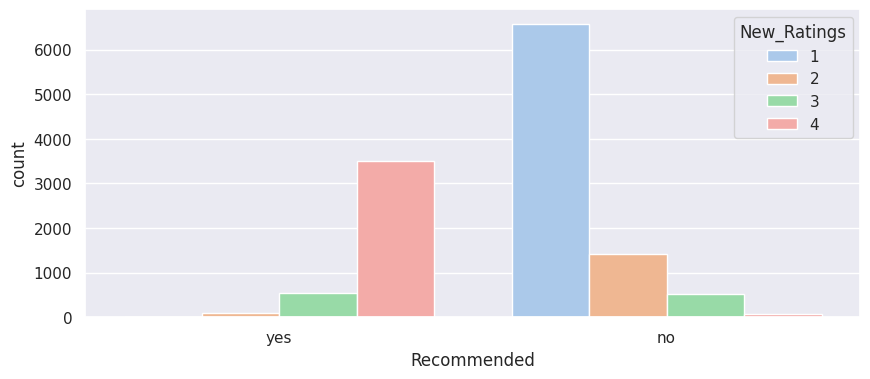

In [ ]:
# It seems like that there is something happened when they submit their reviews. These are clearly good reviews!
# But since do not know exactly how they rate the company? Then, need to drop the realted rows.
i = airline_df[(airline_df['Recommended'] == 'yes') & (airline_df['New_Ratings'] == 1)].index
airline_df = airline_df.drop(i)

# Plot the final results with the same graph
sns.set_theme(style = 'darkgrid', palette = 'pastel')
plt.figure(figsize = (10, 4))
sns.countplot(data = airline_df, x = 'Recommended', hue = 'New_Ratings')

# convert 'Verified' from bool into int type
airline_df['Verified'] = airline_df['Verified'].astype(int)

# Dropping 'Review' columns.
airline_df = airline_df.drop('Review', axis = 1)

In [ ]:
# Data Preprocessing for sentiment analysis
#Lowering all the letters and then saving it in the new column(Review Title).
airline_df['Review Title'] = airline_df['Review_Title'].apply(lambda x: x.lower())

# Removing all punctuation marks.
airline_df['Review Title'] = airline_df['Review Title'].replace(r'[^\w\s\d+]', '', regex = True)

# Tokenizing the titles.
airline_df['Review_Title_Tokenized'] = airline_df['Review Title'].apply(lambda x: word_tokenize(x))

# Removing the stopwords.
stopwords = set(stopwords.words('english'))
airline_df['Review_Title_Tokenized'] = airline_df['Review_Title_Tokenized'].apply(lambda x: [word for word in x if word not in stopwords])

# Pos tagging words. (for more info check this: https://en.wikipedia.org/wiki/Part-of-speech_tagging)
airline_df['Title_pos_tag'] = airline_df['Review_Title_Tokenized'].apply(lambda x: nltk.pos_tag(x))

# It is a function for converting pos tag into wordnet tags.
def to_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('V'):
        return wordnet.VERB
    else:
        return None
airline_df['Title_wordnet_tags'] = airline_df['Title_pos_tag'].apply(lambda x: [(word, to_wordnet_pos(tag)) for (word, tag) in x])

# Lemmatizing the words. (if you don't know what is lemmatizing check this: https://en.wikipedia.org/wiki/Lemmatisation)
lemmatizer = WordNetLemmatizer()
airline_df['Title_lemmatized'] = airline_df['Title_wordnet_tags'].apply(lambda x: [lemmatizer.lemmatize(word, tag) if tag is not None else
                                                                             word for word, tag in x])

# Let's put it together.
airline_df['title_filtered'] = airline_df['Title_lemmatized'].apply(lambda x: ' '.join(x))

airline_df.head()

,Review_Title,Review Date,Verified,Type Of Traveller,Seat Type,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,New_Ratings,Review Title,Review_Title_Tokenized,Title_pos_tag,Title_wordnet_tags,Title_lemmatized,title_filtered
0,"""pretty decent airline""",11th November 2019,1,Solo Leisure,Economy Class,November 2019,4.0,5.0,4.0,4.0,3.0,yes,4,pretty decent airline,"[pretty, decent, airline]","[(pretty, RB), (decent, JJ), (airline, NN)]","[(pretty, r), (decent, a), (airline, n)]","[pretty, decent, airline]",pretty decent airline
1,"""Not a good airline""",25th June 2019,1,Solo Leisure,Economy Class,June 2019,2.0,2.0,1.0,1.0,2.0,no,1,not a good airline,"[good, airline]","[(good, JJ), (airline, NN)]","[(good, a), (airline, n)]","[good, airline]",good airline
2,"""flight was fortunately short""",25th June 2019,1,Solo Leisure,Economy Class,June 2019,2.0,1.0,1.0,1.0,2.0,no,1,flight was fortunately short,"[flight, fortunately, short]","[(flight, NN), (fortunately, RB), (short, JJ)]","[(flight, n), (fortunately, r), (short, a)]","[flight, fortunately, short]",flight fortunately short
4,"""it ruined our last days of holidays""",24th September 2019,1,Couple Leisure,Economy Class,September 2019,1.0,1.0,1.0,1.0,1.0,no,1,it ruined our last days of holidays,"[ruined, last, days, holidays]","[(ruined, VBN), (last, JJ), (days, NNS), (holi...","[(ruined, v), (last, a), (days, n), (holidays,...","[ruin, last, day, holiday]",ruin last day holiday
5,"""Had very bad experience""",17th September 2019,1,Couple Leisure,Economy Class,September 2019,1.0,1.0,1.0,1.0,1.0,no,1,had very bad experience,"[bad, experience]","[(bad, JJ), (experience, NN)]","[(bad, a), (experience, n)]","[bad, experience]",bad experience


In [ ]:
# Removing unnecessary columns.
airline_df = airline_df.drop(['Review_Title','Review Date', 'Date Flown', 'Verified', 'Review Title', 'Review_Title_Tokenized', 'Title_pos_tag',
                        'Title_wordnet_tags', 'Title_lemmatized', 'Type Of Traveller'], axis = 1)

airline_df.head()

,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,New_Ratings,title_filtered
0,Economy Class,4.0,5.0,4.0,4.0,3.0,yes,4,pretty decent airline
1,Economy Class,2.0,2.0,1.0,1.0,2.0,no,1,good airline
2,Economy Class,2.0,1.0,1.0,1.0,2.0,no,1,flight fortunately short
4,Economy Class,1.0,1.0,1.0,1.0,1.0,no,1,ruin last day holiday
5,Economy Class,1.0,1.0,1.0,1.0,1.0,no,1,bad experience


In [ ]:
# Filling null values
airline_df.isnull().sum()

# Since most of the people flight in Economy Class, then fill null values with this.
airline_df['Seat Type'] = airline_df['Seat Type'].fillna('Economy Class')
airline_df['Cabin Staff Service'] = airline_df['Cabin Staff Service'].fillna(airline_df['Cabin Staff Service'].mode())
airline_df['Seat Comfort'] = airline_df['Seat Comfort'].fillna(airline_df['Seat Comfort'].mode())

#@ There are more than 1000 null values for 'Ground Service' column, it is not that many,
# because it's very 'sensitive' feature, wrong 'fillings' may decrease model's performance.
# So, we're going to drop the rows where 'Ground Service's values is null!
airline_df = airline_df.dropna(subset = 'Ground Service', axis = 0)
airline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11532 entries, 0 to 23169
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Seat Type            11532 non-null  object  
 1   Seat Comfort         11532 non-null  float64 
 2   Cabin Staff Service  11532 non-null  float64 
 3   Food & Beverages     11532 non-null  float64 
 4   Ground Service       11532 non-null  float64 
 5   Value For Money      11532 non-null  float64 
 6   Recommended          11532 non-null  object  
 7   New_Ratings          11532 non-null  category
 8   title_filtered       11532 non-null  object  
dtypes: category(1), float64(5), object(3)
memory usage: 822.3+ KB


In [ ]:
# Create dummy variables (Seat Comfort = Business Class, Economy Class, First Class, Premium Economy)
dummie_seat_type = pd.get_dummies(airline_df['Seat Type'])

df_new = pd.concat([airline_df, dummie_seat_type], axis = 1)
# Then remove the previous seat type
df_new = df_new.drop('Seat Type', axis = 1)
df_new.reset_index(drop = True)

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,New_Ratings,title_filtered,Business Class,Economy Class,First Class,Premium Economy
0,4.0,5.0,4.0,4.0,3.0,yes,4,pretty decent airline,0,1,0,0
1,2.0,2.0,1.0,1.0,2.0,no,1,good airline,0,1,0,0
2,2.0,1.0,1.0,1.0,2.0,no,1,flight fortunately short,0,1,0,0
3,1.0,1.0,1.0,1.0,1.0,no,1,ruin last day holiday,0,1,0,0
4,1.0,1.0,1.0,1.0,1.0,no,1,bad experience,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11527,2.0,2.0,1.0,1.0,1.0,no,1,think meal include,0,1,0,0
11528,2.0,2.0,1.0,2.0,1.0,no,1,would refund tax,0,1,0,0
11529,3.0,4.0,1.0,1.0,2.0,no,1,300 saving absolutely worth,0,1,0,0
11530,2.0,4.0,2.0,1.0,2.0,no,2,recommend anyone,0,1,0,0


In [ ]:
# Due to machine can only understand numbers. So, need to convert categorical features into numbers.
# LabelEncoder helps us to convert categorical features into numbers
le = LabelEncoder()

df_new['Recommended'] = le.fit_transform(df_new['Recommended'])
df_new['Recommended'] = df_new['Recommended'].astype(int)

df_new['New_Ratings'] = df_new['New_Ratings'].astype(int)

df_new['Economy Class'] = le.fit_transform(df_new['Economy Class'])
df_new['Economy Class'] = df_new['Economy Class'].astype(int)

df_new['First Class'] = le.fit_transform(df_new['First Class'])
df_new['First Class'] = df_new['First Class'].astype(int)

df_new['Premium Economy'] = le.fit_transform(df_new['Premium Economy'])
df_new['Premium Economy'] = df_new['Premium Economy'].astype(int)

df_new['Business Class'] = le.fit_transform(df_new['Business Class'])
df_new['Business Class'] = df_new['Business Class'].astype(int)

df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11532 entries, 0 to 23169
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Seat Comfort         11532 non-null  float64
 1   Cabin Staff Service  11532 non-null  float64
 2   Food & Beverages     11532 non-null  float64
 3   Ground Service       11532 non-null  float64
 4   Value For Money      11532 non-null  float64
 5   Recommended          11532 non-null  int64  
 6   New_Ratings          11532 non-null  int64  
 7   title_filtered       11532 non-null  object 
 8   Business Class       11532 non-null  int64  
 9   Economy Class        11532 non-null  int64  
 10  First Class          11532 non-null  int64  
 11  Premium Economy      11532 non-null  int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 1.1+ MB


In [ ]:
# CountVectorizer converts a collection of text documents to a matrix of token counts.
# Setting min_df = 0.001 means, that any word which can used under 0.001 of samples will be removed.
vectorizer = CountVectorizer(min_df = 0.001)

# Created a pandas dataframe with all the worlds in 'title_filtered' column. Each word represents as a column.
vectorized = vectorizer.fit_transform(df_new['title_filtered'])
vectorized_df = pd.DataFrame(vectorized.toarray(), columns = vectorizer.get_feature_names_out())

vectorized_df.head()

,15,absolute,absolutely,acceptable,adequate,aeromexico,air,airasia,aircraft,airline,...,wonderful,wont,work,worst,worth,would,wouldnt,year,yet,zero
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_new = df_new.reset_index(drop = True)

# Concatinating 'main' dataframe with 'vectorized_df'
df_final = pd.concat([df_new, vectorized_df], axis = 1)
df_final = df_final.drop('title_filtered', axis = 1)

df_final.head()

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,New_Ratings,Business Class,Economy Class,First Class,...,wonderful,wont,work,worst,worth,would,wouldnt,year,yet,zero
0,4.0,5.0,4.0,4.0,3.0,1,4,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,2.0,1.0,1.0,2.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1.0,1.0,1.0,2.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1.0,1.0,1.0,1.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,1.0,1.0,1.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Use MinMaxScaler for feature scaling because MultinomialNaiveBayes does not allow negative values.
scaler = MinMaxScaler()
X = scaler.fit_transform(df_final.drop('New_Ratings', axis = 1))
y = df_final['New_Ratings']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [ ]:
# Modeling using different algorithms

# Multinomial Naive Bayes - This is very good when dealing with text data.
# Gradient Boosting Classifier - GB can handle many type of data
# Voting Classifier - Using voting classifier we can combine different models.

mnb = MultinomialNB()

gb_clf = GradientBoostingClassifier()

# Setting 'voting' parameter to soft will make the classifier to classify by probobalities.
vot_clf = VotingClassifier(estimators = [('mnb', mnb), ('gb_clf', gb_clf)], voting = 'soft')

model_names = ['MultinomialNB', 'GradientBoost', 'VotingClassifier']
models = [mnb, gb_clf, vot_clf]
count = 0
for model in models:
    cvalscore = cross_val_score(model, X_train, y_train, scoring = 'accuracy', cv = 5)
    print('Accuracy of {}: '.format(model_names[count]), cvalscore.mean())
    count = count + 1

Accuracy of MultinomialNB:  0.7731165311653116
Accuracy of GradientBoost:  0.815609756097561
Accuracy of VotingClassifier:  0.8092140921409214


In [ ]:
# Gradient Boost fit to the data and then measure the accuracy score.
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
print('Accuracy of GradientBoost: ', accuracy_score(y_test, y_pred))

Accuracy of GradientBoost:  0.8292154312960555


Text(0.5, 1.0, 'Confusion Matrix')

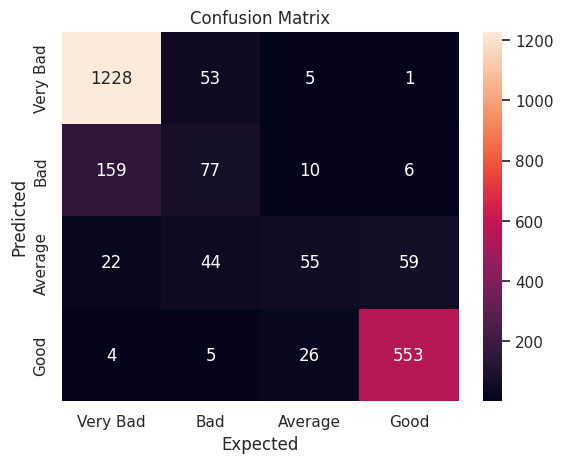

In [ ]:
# Confusion Matrix
classes = ['Very Bad', 'Bad', 'Average', 'Good']
scores = confusion_matrix(y_test, y_pred)
sns.set_theme(palette = 'pastel')
sns.heatmap(scores, annot = True, fmt = 'd', xticklabels = classes, yticklabels = classes)
plt.xlabel('Expected')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')



In [ ]:
###################################################################
# Alternative METHOD using the code inherit from Geraldine
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import nltk
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

# Make confirmation
# Displaying the first few rows of the updated DataFrame to verify the combination
airline_data_reduced.head()

,Airline Name,Overall_Rating,Review_Title,Review,Recommended,Combined_Review,Processed_Review,Spacy_Entities
0,AB Aviation,9.0,"""pretty decent airline""",Moroni to Moheli. Turned out to be a pretty ...,yes,"""pretty decent airline"" Moroni to Moheli. Tu...",pretty decent airline Moroni Moheli Turned pre...,"[(Moheli Turned, ORG), (Online, ORG), (20 minu..."
1,AB Aviation,1.0,"""Not a good airline""",Moroni to Anjouan. It is a very small airline...,no,"""Not a good airline"" Moroni to Anjouan. It is...",Not good airline Moroni Anjouan It small airli...,"[(Anjouan, PERSON), (AB Aviation, ORG), (1300h..."
2,AB Aviation,1.0,"""flight was fortunately short""",Anjouan to Dzaoudzi. A very small airline an...,no,"""flight was fortunately short"" Anjouan to Dz...",flight fortunately short Anjouan Dzaoudzi A sm...,"[(Anjouan Dzaoudzi, PERSON), (Comoros Checkin,..."
3,Adria Airways,1.0,"""I will never fly again with Adria""",Please do a favor yourself and do not fly wi...,no,"""I will never fly again with Adria"" Please d...",I never fly Adria Please favor fly Adria On ro...,"[(Adria Please, PERSON), (Adria, ORG), (Munich..."
4,Adria Airways,1.0,"""it ruined our last days of holidays""",Do not book a flight with this airline! My fr...,no,"""it ruined our last days of holidays"" Do not ...",ruined last days holidays Do book flight airli...,"[(last days holidays, DATE), (Sofia, GPE), (Se..."


In [ ]:
# Create a new dataset and select certain column for Sentiment Analysis
airline_sentiment = airline_data_reduced.loc[:, ['Processed_Review','Recommended']]

airline_sentiment.head(10)

,Processed_Review,Recommended
0,pretty decent airline Moroni Moheli Turned pre...,yes
1,Not good airline Moroni Anjouan It small airli...,no
2,flight fortunately short Anjouan Dzaoudzi A sm...,no
3,I never fly Adria Please favor fly Adria On ro...,no
4,ruined last days holidays Do book flight airli...,no
5,Had bad experience Had bad experience rerouted...,no
6,worse budget airlines Ljubljana Zürich Firstly...,no
7,book another company First I complaining speci...,no
8,combined two flights Worst Airline ever They c...,no
9,crew nice Ljubljana Munich The homebase airpor...,yes


In [ ]:
airline_sentiment.Recommended.value_counts()

no     15364
yes     7807
Name: Recommended, dtype: int64

In [ ]:
# Bag of Words features (BOW)
# The preprocessed dataset is now ready. One last step is to convert it to numerical form (as machines only understand mathematical operations).
# Apply the bag-of-words technique to convert the dataset into numerical form.

# Bag of Words is a natural language processing(NLP) technique that is used to represent
# a text document into numerical form by considering the occurrence of words in the given document.
# It considers only two things - 1. A vocabulary of words, 2. presence(or frequency) of a word in a given document ignoring the order of the words(or grammar).
airline_train = airline_sentiment[:18000]
airline_test = airline_sentiment[18000:]

In [ ]:
# Method 1 - use CountVectorizer from the sklearn package to get the bag-of-words representation of the training and testing dataset.
# Note: Will only consider training dataset to define the vocabulary and use the same vocabulary to represent the test dataset (as test data is supposed to be hidden).
# Thus, fit the vectorizer on the training data and use it to transform the test data
vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
tf_features_train = vectorizer.fit_transform(airline_train['Processed_Review'])
tf_features_test = vectorizer.transform(airline_test['Processed_Review'])
print (tf_features_train.shape, tf_features_test.shape)

# (18000, 35972) means that there are 35972 unique English words in the vocabulary (derived from the training dataset)
# and each word is represented with a unique column in the dataset.

(18000, 35972) (5171, 35972)


In [ ]:
# Note: binary=False argument means that it fill the vocabulary vector with term-frequency.
# If binary=True, the vocabulary vector is filled by the presence of words (1 if the word is present and 0 otherwise).

# Let’s convert the output labels into the numerical form.
# Yes Recommended is represented by 1, while No Recommended is represented with 0.

train_labels = [1 if Recommended=='yes' else 0 for Recommended in airline_train['Recommended']]
test_labels = [1 if Recommended=='yes' else 0 for Recommended in airline_test['Recommended']]
print (len(train_labels), len(test_labels))

18000 5171


In [ ]:
# Logistic Regression for sentiment analysis

# Bag-of-words features
# Unigrams: All unique words in a document
# BiGrams: All permutations of two consecutive words in a document
# TriGrams: All permutations of three consecutive words in a document

# UniGram bag-of-words features
# When the Bag of Words algorithm considers only single unique words in the vocabulary, the feature set is said to be UniGram.
# Let’s define train Logistic Regression classifier on unigram features:

clf = sklearn.linear_model.LogisticRegression()
clf.fit(tf_features_train, train_labels)

LogisticRegression()

In [ ]:
# Unigrams (Logistic Regression)
predictions = clf.predict(tf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1]))

              precision    recall  f1-score   support

    Negative       0.91      0.93      0.92      3515
    Positive       0.85      0.80      0.83      1656

    accuracy                           0.89      5171
   macro avg       0.88      0.87      0.87      5171
weighted avg       0.89      0.89      0.89      5171

[[3276  239]
 [ 325 1331]]


In [ ]:
# Unigrams + Bigrams (Logistic Regression)
# Let’s repeat the same exercise with UniGram +BiGram features.
# This time the Bag-of-Words algorithm also considers consecutive pairs of words in the dictionary along with unique words.
# Then calculate these features by simply changing the ngram_range parameter to (1,2).

vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
tf_features_train = vectorizer.fit_transform(airline_train['Processed_Review'])
tf_features_test = vectorizer.transform(airline_test['Processed_Review'])
print (tf_features_train.shape, tf_features_test.shape)

clf = sklearn.linear_model.LogisticRegression()
clf.fit(tf_features_train, train_labels)

predictions = clf.predict(tf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1]))

# The feature set size increases as there are considering Bi-Grams also.
# This time the model performs a little better as it have passed more information. Accuracy on test-set is now 91%.

(18000, 664865) (5171, 664865)
              precision    recall  f1-score   support

    Negative       0.93      0.94      0.93      3515
    Positive       0.87      0.84      0.85      1656

    accuracy                           0.91      5171
   macro avg       0.90      0.89      0.89      5171
weighted avg       0.91      0.91      0.91      5171

[[3300  215]
 [ 259 1397]]


In [ ]:
# Unigrams + Bigrams + Trigrams (Logistic Regression)
# Repeat the same exercise after adding Tri-Gram features also into the feature set.
# This time also consider three consecutive word permutations also into the vocabulary.
vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))
tf_features_train = vectorizer.fit_transform(airline_train['Processed_Review'])
tf_features_test = vectorizer.transform(airline_test['Processed_Review'])
print (tf_features_train.shape, tf_features_test.shape)

clf = sklearn.linear_model.LogisticRegression()
clf.fit(tf_features_train, train_labels)

predictions = clf.predict(tf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1]))

# This time do not see any significant increase in the accuracy.

(18000, 1806974) (5171, 1806974)
              precision    recall  f1-score   support

    Negative       0.93      0.94      0.93      3515
    Positive       0.87      0.84      0.86      1656

    accuracy                           0.91      5171
   macro avg       0.90      0.89      0.90      5171
weighted avg       0.91      0.91      0.91      5171

[[3312  203]
 [ 261 1395]]


In [ ]:
# Linear Support Vector Machine (LSVM) for sentiment analysis
# Repeat the same exercise with Linear support vector machine(LSVM) classification result
# in order to check that which algorithms gives to best results.

# Unigram (LSVM)
vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
tf_features_train = vectorizer.fit_transform(airline_train['Processed_Review'])
tf_features_test = vectorizer.transform(airline_test['Processed_Review'])
print (tf_features_train.shape, tf_features_test.shape)

clf = sklearn.svm.LinearSVC()
clf.fit(tf_features_train, train_labels)

predictions = clf.predict(tf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1]))

# Using this model achieves 86% accuracy on test dataset which is slightly lower to what Logistic regression achieved.

(18000, 35972) (5171, 35972)
              precision    recall  f1-score   support

    Negative       0.89      0.91      0.90      3515
    Positive       0.81      0.77      0.79      1656

    accuracy                           0.87      5171
   macro avg       0.85      0.84      0.84      5171
weighted avg       0.87      0.87      0.87      5171

[[3208  307]
 [ 384 1272]]


In [ ]:
# UniGrams + BiGrams (LSVM)
vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
tf_features_train = vectorizer.fit_transform(airline_train['Processed_Review'])
tf_features_test = vectorizer.transform(airline_test['Processed_Review'])
print (tf_features_train.shape, tf_features_test.shape)

clf = sklearn.svm.LinearSVC()
clf.fit(tf_features_train, train_labels)

predictions = clf.predict(tf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1]))

# And Yes. This time model achieves an accuracy of 90% on test set. Now LSVM is very close to the Logistic Regression results.

(18000, 664865) (5171, 664865)
              precision    recall  f1-score   support

    Negative       0.93      0.93      0.93      3515
    Positive       0.86      0.84      0.85      1656

    accuracy                           0.90      5171
   macro avg       0.89      0.89      0.89      5171
weighted avg       0.90      0.90      0.90      5171

[[3282  233]
 [ 266 1390]]


In [ ]:
# UniGrams + BiGrams + TriGrams (LSVM)
vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))
tf_features_train = vectorizer.fit_transform(airline_train['Processed_Review'])
tf_features_test = vectorizer.transform(airline_test['Processed_Review'])
print (tf_features_train.shape, tf_features_test.shape)

clf = sklearn.svm.LinearSVC()
clf.fit(tf_features_train, train_labels)

predictions = clf.predict(tf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1]))

# Again, similar to Logistic Regression results, model improve slightly after addition of TriGram features. Accuracy stands at 91% only.

(18000, 1806974) (5171, 1806974)
              precision    recall  f1-score   support

    Negative       0.93      0.94      0.93      3515
    Positive       0.87      0.85      0.86      1656

    accuracy                           0.91      5171
   macro avg       0.90      0.89      0.89      5171
weighted avg       0.91      0.91      0.91      5171

[[3299  216]
 [ 254 1402]]


In [ ]:
# Naive Bayes for sentiment analysis
# So far that Logistic Regression and LSVM are giving an almost similar performance on test set and achieve an accuracy of 90% with UniGram + BiGram feature sets.
# And will do a similar iterations for the Multinomial Naive Bayes algorithm also.

# Unigrams (Naive Bayes)
from sklearn.naive_bayes import MultinomialNB

vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
tf_features_train = vectorizer.fit_transform(airline_train['Processed_Review'])
tf_features_test = vectorizer.transform(airline_test['Processed_Review'])
print (tf_features_train.shape, tf_features_test.shape)

clf = MultinomialNB()
clf.fit(tf_features_train, train_labels)

predictions = clf.predict(tf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1]))

# Results are not much encouraging this time. It get the lowest accuracy with MNB classifier on the test data.
# Let’s try adding more information to check if it improves from existing 87% accuracy.

(18000, 35972) (5171, 35972)
              precision    recall  f1-score   support

    Negative       0.94      0.87      0.90      3515
    Positive       0.76      0.88      0.82      1656

    accuracy                           0.87      5171
   macro avg       0.85      0.87      0.86      5171
weighted avg       0.88      0.87      0.87      5171

[[3055  460]
 [ 200 1456]]


In [ ]:
# Unigram+BiGrams (Naive Bayes)

vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
tf_features_train = vectorizer.fit_transform(airline_train['Processed_Review'])
tf_features_test = vectorizer.transform(airline_test['Processed_Review'])
print (tf_features_train.shape, tf_features_test.shape)

clf = MultinomialNB()
clf.fit(tf_features_train, train_labels)

predictions = clf.predict(tf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1]))

# Accuracy has improved only 1% from the previous iteration but it still 2% below the results the other two approaches have given

(18000, 664865) (5171, 664865)
              precision    recall  f1-score   support

    Negative       0.90      0.92      0.91      3515
    Positive       0.83      0.79      0.81      1656

    accuracy                           0.88      5171
   macro avg       0.87      0.86      0.86      5171
weighted avg       0.88      0.88      0.88      5171

[[3246  269]
 [ 348 1308]]


In [ ]:
# UniGrams + BiGrams + TriGrams (Naive Bayes)
vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))
tf_features_train = vectorizer.fit_transform(airline_train['Processed_Review'])
tf_features_test = vectorizer.transform(airline_test['Processed_Review'])
print (tf_features_train.shape, tf_features_test.shape)

clf = MultinomialNB()
clf.fit(tf_features_train, train_labels)

predictions = clf.predict(tf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1]))

# And NO, this model is not any better from the last iteration.
# Do not see any accuracy improvements after adding TriGrams into the feature set. Result stands at 87%.

(18000, 1806974) (5171, 1806974)
              precision    recall  f1-score   support

    Negative       0.87      0.94      0.91      3515
    Positive       0.86      0.71      0.78      1656

    accuracy                           0.87      5171
   macro avg       0.86      0.83      0.84      5171
weighted avg       0.87      0.87      0.87      5171

[[3318  197]
 [ 482 1174]]


In [ ]:
# Summary– (Sentiment Analysis)

# Model - (UniGrams), (Uni+BiGrams), (Uni+Bi+TriGrams)
# Logistic Regression - 89%, 91%, 91%
# Linear SVM - 87%, 90%, 91%
# MultiNomial Naive Bayes - 87%, 88%, 87%

# It can see that Logistic Regression and LSVM perform equally well and achieve an accuracy of 90% while the MNB classifier gives a slightly lower accuracy of 88%.
# Logistic Regression model with Unigram+BiGram bag-of-words features can be considered as the best model from this case study.

In [ ]:
#Nathaniel's part - Text summarization
import nltk
import heapq
from sklearn.feature_extraction.text import TfidfVectorizer

def getTextFromDataFrameRow(row):
    # Assuming the row contains text data
    if pd.notna(row):  # Check if the row is not empty
        return str(row)
    return ""

def getSentScores(text, sentences, mode):
    sentence_scores = {}

    if not text.strip():
        # If the text is empty or contains only whitespace, return an empty dictionary
        return sentence_scores

    if mode == 'nltk':
        stopwords = nltk.corpus.stopwords.words('english')
        word_freqs = {}

        # calculate word frequencies in the main text
        for word in nltk.word_tokenize(text):
            if word not in stopwords:
                if word not in word_freqs.keys():
                    word_freqs[word] = 1
                else:
                    word_freqs[word] += 1

        # Check if word_freqs is not empty
        if word_freqs:
            # normalize word frequencies
            max_freq = max(word_freqs.values())

            for word in word_freqs.keys():
                word_freqs[word] = (word_freqs[word] / max_freq)

            # iterate over sentences and calculate sentence scores
            for sent in sentences:
                # skip sentences with more than or equal to 30 words
                if len(sent.split(' ')) >= 30:
                    continue
                # tokenize and lowercase words in the sentence
                for word in nltk.word_tokenize(sent.lower()):
                    # check if the word is in word_freqs
                    if word in word_freqs.keys():
                        # update sentence_scores dictionary wwith word frequencies
                        if sent not in sentence_scores.keys():
                            sentence_scores[sent] = word_freqs[word]
                        else:
                            sentence_scores[sent] += word_freqs[word]

    return sentence_scores

def getSummaryForTopAndLastRows(data_frame, column_name, mode, top_rows=10, last_rows=10):
    total_rows = len(data_frame)

    # Summarize top rows
    print(f"Summarizing the top {top_rows} rows:")
    for index in range(top_rows):
        row = data_frame.iloc[index]
        text = getTextFromDataFrameRow(row[column_name])

        if not text.strip():
            print(f"Skipping empty row {index}")
            print("*********************************************")
            continue

        # tokenized text into a list of sentences
        sentences = nltk.sent_tokenize(text)
        # calculate sentence scores based on word frequencies
        sentence_scores = getSentScores(text, sentences, mode)
        # select top 7 sentences based on their scores
        summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)
        # selected top sentences are joined into summary
        summary = ' '.join(summary_sentences)

        if summary:
            print(f"Row {index}: {summary}")
            print("*********************************************")
        else:
            print(f"No summary for Row {index}")
            print("*********************************************")

    # Summarize last rows
    print(f"\nSummarizing the last {last_rows} rows:")
    for index in range(total_rows - last_rows, total_rows):
        row = data_frame.iloc[index]
        text = getTextFromDataFrameRow(row[column_name])

        if not text.strip():
            print(f"Skipping empty row {index}")
            print("*********************************************")
            continue

        sentences = nltk.sent_tokenize(text)
        sentence_scores = getSentScores(text, sentences, mode)
        summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)
        summary = ' '.join(summary_sentences)

        if summary:
            print(f"Summary for Row {index}: {summary}")
            print("*********************************************")
        else:
            print(f"No summary for Row {index}")
            print("*********************************************")

# name of the column that want to summarize
column_name = 'Review'

print("\nText Summarization using NLTK:\n")
getSummaryForTopAndLastRows(airline_data_reduced, column_name, 'nltk', top_rows=10, last_rows=10)


Text Summerization using NLTK:

Summarizing the top 10 rows:
Row 0: Online booking worked well, checkin and boarding was fine and the plane looked well maintained. Turned out to be a pretty decent airline. Both flights on time.   Moroni to Moheli.
*********************************************
Row 1: It opened at 0900hrs and I was told that the flight had been put back to 1300hrs and that they had tried to contact me. The later flight did operate but as usual, there was confusion at check-in. There was confusion at this small airport. The flight was only 30mins and there were no further problems. It is a very small airline. My ticket advised me to turn up at 0800hrs which I did. I was then directed to the office of AB Aviation which was still closed.
*********************************************
Row 2: With a short flight like there was of course no in-flight entertainment nor cabin service except for biscuits and a bottle of water, which was quite nice! The flight was fortunately shor